# Manipulating fMRI exams from the ABIDE I Preprocessed Connectomes Project

The ABIDE I [Preprocessed Connectomes Project](http://preprocessed-connectomes-project.org/abide/download.html) is a dataset that contains the BOLD time series for each ABIDE I fMRI sample for each ROI, using several different brain atlases.

Import libraries

In [4]:
import networkx as nx
import numpy as np
import torch

Obtaining data from the ABIDE I [Preprocessed Connectomes Project](http://preprocessed-connectomes-project.org/abide/download.html). We're going to use the AAL atlas, which uses 116 brain regions of interest.

In [5]:
!wget https://s3.amazonaws.com/fcp-indi/data/Projects/ABIDE_Initiative/Outputs/cpac/filt_global/rois_aal/KKI_0050822_rois_aal.1D

--2024-12-27 18:23:56--  https://s3.amazonaws.com/fcp-indi/data/Projects/ABIDE_Initiative/Outputs/cpac/filt_global/rois_aal/KKI_0050822_rois_aal.1D
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.114.125, 3.5.22.99, 16.15.177.46, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.114.125|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 174414 (170K) [application/octet-stream]
Saving to: ‘KKI_0050822_rois_aal.1D’

KKI_0050822_rois_aa 100%[===================>] 170.33K   919KB/s    in 0.2s    

2024-12-27 18:23:57 (919 KB/s) - ‘KKI_0050822_rois_aal.1D’ saved [174414/174414]



In [6]:
roi_time_series = np.loadtxt('/content/KKI_0050822_rois_aal.1D')
roi_time_series

array([[  1.672549,  -1.607909,  -2.211471, ...,   2.952253,  -7.954664,
         11.912945],
       [  3.735894,   2.587415,  -1.257845, ...,  -3.058335, -20.353283,
         28.906689],
       [  5.261487,   6.809807,   1.339608, ...,  -5.455   , -31.063692,
         13.629085],
       ...,
       [  5.375271,  11.737147, -14.061418, ...,   5.064894,  30.168876,
         -4.859138],
       [  0.759041,  12.359924, -14.291751, ...,  -3.190382, -25.511915,
        -39.867251],
       [ -0.889572,   2.504502,  -6.669948, ...,   2.26924 , -38.283624,
        -28.39076 ]])

In [7]:
roi_time_series.shape

(152, 116)

In [10]:
def torch_pearson_correlation_matrix(X):

  mean = torch.mean(X, dim=0)
  covariance = torch.matmul((X - mean).t(), (X - mean))
  variance = torch.diagonal(covariance)
  correlation = (variance**(-1/2)) * covariance * ((variance**(-1/2)).t())
  return correlation

def construct_graph(roi_time_series, threshold=0.7, return_functional_connectivity=True, adjacency_matrix_type='torch'):

  roi_time_series = torch.from_numpy(roi_time_series)
  functional_connectivity = torch_pearson_correlation_matrix(roi_time_series)
  adjacency_matrix = (functional_connectivity > threshold).int() - torch.eye(len(functional_connectivity))

  if adjacency_matrix_type == 'numpy':
    adjacency_matrix = adjacency_matrix.numpy()

  if return_functional_connectivity==True:
    return adjacency_matrix, functional_connectivity
  else:
    return adjacency_matrix

In [21]:
adjacency_matrix = construct_graph(roi_time_series, return_functional_connectivity=False, adjacency_matrix_type='numpy')
G = nx.from_numpy_array(adjacency_matrix)

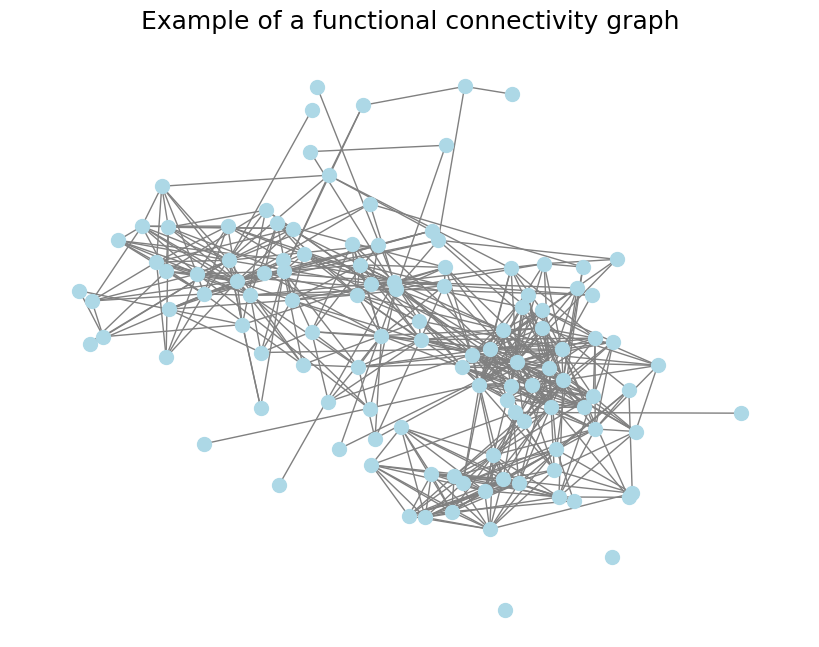

In [22]:
import matplotlib.pyplot as plt

pos = nx.spring_layout(G, seed=42, k=0.5)
plt.figure(figsize=(8, 6))
nx.draw(
    G,
    pos,
    node_color='lightblue',
    node_size=100,
    font_size=15,
    font_color='black',
    edge_color='gray'
)
plt.title("Example of a functional connectivity graph", fontsize=18)
plt.show()